# What is P('covfefe')?

Author: Daniel Lowd <lowd@cs.uoregon.edu>, May 2017.

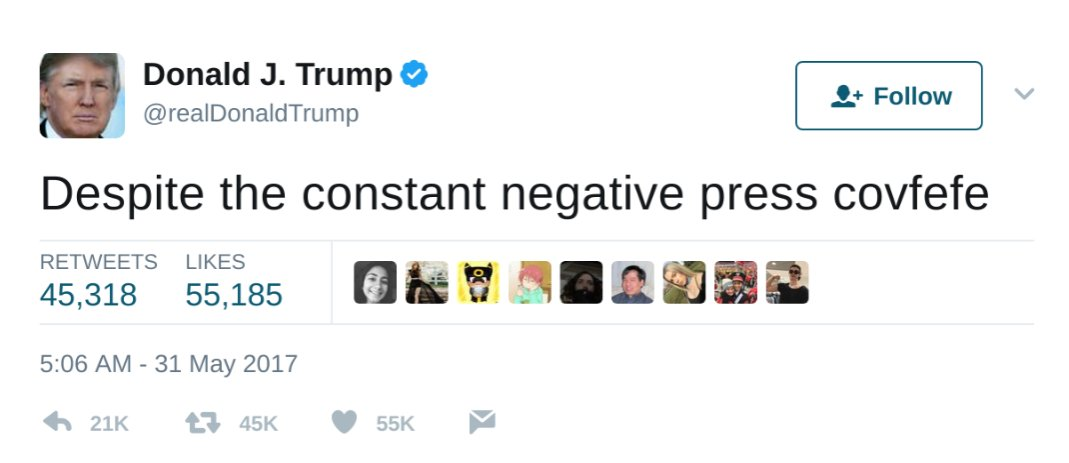

What is a 'covfefe'? And how would anyone (or anything) come up with such a word?

In this notebook, we'll estimate the probability of generating unusual words such as 'covfefe' with a simple Markov chain. In this Markov chain, the first letter is chosen at random with probability $P(X_1)$, and each subsequent letter is chosen randomly based on the previous letter, with probability $P(X_i | X_{i-1})$ where $X_i$ is the $i$th letter and $X_{i-1}$ is the previous letter. Thus, the total probability of a $k$-letter word is: $P(x_1, \ldots, x_k) = P(x_1) \prod_{i=2}^k P(x_i | x_{i-1})$.

First, we read in a list of bigram counts (source: https://gist.github.com/lydell/c439049abac2c9226e53) and use them to generate unigram counts.

In [33]:
import json

# Read in bigram (letter-pair) counts
with open('bigrams.json') as bigram_file:
    bigrams = dict(json.load(bigram_file))

# Generate unigram (single-letter) counts from bigrams
unigrams = dict()
for k in bigrams:
    first_letter = k[0]
    if first_letter not in unigrams:
        unigrams[first_letter] = 0
    unigrams[first_letter] += bigrams[k]
    
unigrams

{u'a': 265558007702,
 u'b': 51990721637,
 u'c': 114668162543,
 u'd': 61773859589,
 u'e': 295389985133,
 u'f': 50568628169,
 u'g': 44752229042,
 u'h': 159902640250,
 u'i': 264137445721,
 u'j': 5496578273,
 u'k': 13295161369,
 u'l': 119227774548,
 u'm': 77191787274,
 u'n': 188518688012,
 u'o': 241206426841,
 u'p': 72084698434,
 u'q': 4199576492,
 u'r': 179885727875,
 u's': 136105274802,
 u't': 263807337660,
 u'u': 94383229346,
 u'v': 37124853560,
 u'w': 53605001884,
 u'x': 7141081688,
 u'y': 14684354222,
 u'z': 2963623433}

We use the unigram probabilities to estimate the probability of each letter coming first. (This could be improved by using the actual distribution for the first letter of a word, since some letters may be more or less common at the beginning of a word.)

In [34]:
# Estimate P(X_0)
total_counts = sum([unigrams[c] for c in unigrams])
p_first_letter = {c: float(unigrams[c])/total_counts for c in unigrams}
p_first_letter

{u'a': 0.09418076603878367,
 u'b': 0.01843863053896886,
 u'c': 0.04066733096099427,
 u'd': 0.02190824320309308,
 u'e': 0.10476074632714356,
 u'f': 0.017934281777830064,
 u'g': 0.015871482278359172,
 u'h': 0.056709843851775604,
 u'i': 0.09367696042307697,
 u'j': 0.0019493742885892868,
 u'k': 0.004715159950088124,
 u'l': 0.042284407980010104,
 u'm': 0.027376247172053926,
 u'n': 0.06685859185056277,
 u'o': 0.08554442116034945,
 u'p': 0.025565006218178896,
 u'q': 0.0014893895856413638,
 u'r': 0.06379689242782373,
 u's': 0.04827005276058553,
 u't': 0.09355988683026915,
 u'u': 0.03347323214969857,
 u'v': 0.013166415795987055,
 u'w': 0.01901113878897179,
 u'x': 0.002532601255527137,
 u'y': 0.005207840431476439,
 u'z': 0.0010510559541614146}

We can similarly obtain the probability of the next letter by dividing the counts for each bigram by the counts for its first letter. For example, the probability that 't' is followed by 'h' can be estimated as the number of times 'th' appears divided by the number of times 't' appears. These are maximum likelihood parameter estimates.

In [35]:
# Estimate P(X_t | X_t-1)
p_next_letter = {k: float(bigrams[k])/unigrams[k[0]] for k in bigrams}
print p_next_letter['aa']
print p_next_letter['ab']
print p_next_letter['ac']
print p_next_letter['ad']

0.00030047968687
0.0243984442761
0.0475439113934
0.0390691681218


Now we're ready to compute the probability of a particular character sequence. Since the raw probability is likely to be very small (and could underflow), we work with log probabilities instead.

In [36]:
# Compute P(x_1, x_2, ..., x_n) given P(X_1), P(X_t | X_t-1), and a particular x
from math import log
def word_log_prob(w):
    # Make a list of all bigrams appearing in the word
    w_bigrams = [w[i:(i+2)] for i in xrange(len(w)-1)]
    # Add up the total log probability for the first letter, and then each letter given the previous
    return log(p_first_letter[w[0]]) + sum([log(p_next_letter[b]) for b in w_bigrams])

Let's test it out on a few words and see how likely they are:

In [37]:
print "log P('hi') = ",word_log_prob('hi')
print "log P('hello') = ",word_log_prob('hello')
print "log P('goodbye') = ",word_log_prob('goodbye')
print "log P('thththt') = ",word_log_prob('thththt')
print "log P('ooooooo') = ",word_log_prob('ooooooo')
print "log P('covfefe') = ",word_log_prob('covfefe')

log P('hi') =  -4.87535055874
log P('hello') =  -10.8493060948
log P('goodbye') =  -24.8587977702
log P('thththt') =  -16.5935871747
log P('ooooooo') =  -24.6939085086
log P('covfefe') =  -27.0075346654


Note that, since these are *log* probabilities, a negative number means a very small (positive) probability. Interestingly, 'thththt' is more probable than some actual words, like 'goodbye'. Also, longer words will generally be less probable than shorter ones, since each additional character reduces the probability.

Let's go ahead and compute the probability of *every* word now. First, I filter the words to remove those that have unusual unicode characters or character sequences with probability zero. (This is a hack and could probably be improved upon.)

Word list taken from here: https://github.com/jacksonrayhamilton/wordlist-english/blob/master/english-words.json

In [38]:
def word_ok(w):
    if len(w) == 0:
        return False
    
    for i in xrange(len(w)-1):
        b = w[i:(i+2)]
        if b not in p_next_letter or p_next_letter[b] <= 0.0:
            return False
    return True
   
with open('english.json') as english_words:
    all_words = json.load(english_words)
filtered_words = list(filter(word_ok, all_words))
filtered_words[0:10]

[u'a',
 u'aah',
 u'aalii',
 u'aardvark',
 u'aardvarks',
 u'aardwolf',
 u'aardwolves',
 u'aba',
 u'abaca',
 u'abacas']

We can now order words by their log probability. Here are the 20 least likely words, according to this simple probabilistic model:

In [39]:
for w in sorted(filtered_words, key=word_log_prob)[0:20]:
    print word_log_prob(w), w

-132.689799653 pneumonoultramicroscopicsilicovolcanoconiosis
-87.1215821086 dichlorodiphenyltrichloroethane
-86.743334914 supercalifragilisticexpialidocious
-84.9484285929 floccinaucinihilipilification
-78.3460008158 hippopotomonstrosesquipedalian
-71.6325902709 antidisestablishmentarianisms
-68.2710748013 honorificabilitudinitatibus
-68.2485483025 antidisestablishmentarianism
-67.9758594439 magnetohydrodynamics
-65.0761121133 electroencephalographs
-63.8490789965 electroencephalography
-63.7210975864 electroencephalographic
-63.7117375055 pseudohermaphroditism
-62.791647765 pneumoencephalogram
-62.7211321908 tetrahydrocannabinol
-61.9701190306 succinylsulfathiazole
-61.918900404 dichlorodifluoromethane
-61.1327999353 dihydrostreptomycin
-60.5248893486 unselfconsciousnesses
-59.7105177312 otorhinolaryngologists


We can normalize by length to find the least likely words /per character/:

In [40]:
for w in sorted(filtered_words, key=lambda k: word_log_prob(k)/len(k))[0:20]:
    print word_log_prob(w)/len(w), w

-6.98429163443 cwm
-6.85795994953 z
-6.58524188885 hhd
-6.50938891703 q
-6.34945882842 lx
-6.32997930789 qi
-6.24024683555 j
-6.08422921792 cwms
-5.9785083402 x
-5.93948645704 yuk
-5.8276271401 yukky
-5.80856724241 kb
-5.7348982062 pyx
-5.72384863259 uh
-5.66993589435 aah
-5.62744921224 kudzu
-5.49389211744 qophs
-5.46647176555 dkl
-5.45993067497 guvs
-5.45289453045 kohl


In [41]:
for w in sorted(filtered_words, key=word_log_prob, reverse=True)[0:20]:
    print word_log_prob(w), w

-2.25607613521 e
-2.36253930043 a
-2.3679030066 i
-2.36915354686 t
-2.45871949222 o
-2.70517545938 n
-2.75205079785 r
-2.86980747041 h
-3.03094393628 s
-3.16333686656 l
-3.20233018794 c
-3.39700919986 u
-3.48194943694 he
-3.59807953309 m
-3.66653080722 p
-3.71614981739 in
-3.82089231101 d
-3.88817718409 er
-3.91947516422 an
-3.94861864112 the


In [42]:
for w in sorted(filtered_words, key=lambda k: word_log_prob(k)/len(k), reverse=True)[0:20]:
    print word_log_prob(w)/len(w), w

-1.31620621371 the
-1.36326386105 there
-1.48080586237 then
-1.49843550231 anther
-1.52494366927 thither
-1.53000427751 these
-1.58741252527 here
-1.60221256086 tithe
-1.60719397553 tither
-1.60891230205 heather
-1.61781639193 theses
-1.62645569136 thereat
-1.63673087562 ingather
-1.63908166017 renderer
-1.63959895943 antheses
-1.64625473133 latherer
-1.65231421713 ingathered
-1.65692035629 tinder
-1.65784141055 heathen
-1.67174942868 hinderer


How unlikely is 'covfefe' compared to other 7-letter words?

In [43]:
seven_letter_words = list(filter(lambda w: len(w) == 7, filtered_words)) + ['covfefe']
words_by_prob = sorted(seven_letter_words, key=lambda w: word_log_prob(w))
rank = words_by_prob.index('covfefe')
print rank, "out of ", len(seven_letter_words)

143 out of  15090


Here are the words near 'covfefe' in terms of probability:

In [44]:
words_by_prob[(rank-10):(rank+11)]

[u'postbox',
 u'goshawk',
 u'hautboy',
 u'slipway',
 u'snuffly',
 u'waxwork',
 u'hogback',
 u'obloquy',
 u'webpage',
 u'zymurgy',
 'covfefe',
 u'upchuck',
 u'rhubarb',
 u'dahlias',
 u'bigwigs',
 u'jawbone',
 u'axseeds',
 u'dipnoan',
 u'pygmies',
 u'buyback',
 u'showbiz']

So there we have it! The word 'covfefe' is an unusual sequence of characters, but a few other words have even more unusual character sequences, at least according to a simple Markov chain.